
# Simulator-based unsupervised detection and tracking of worms

**References**

    1. Wu, Hao, et al. Amortized population Gibbs samplers with neural
       sufficient statistics. ICML 2020.

<img src="file://../_static/wormsim.gif" align="center">


In [1]:
import argparse
from functools import partial, reduce

import coix
from coix.core import detach
from coix.api import compose, propose
from coix import util
import flax.linen as nn
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from optax import cosine_decay_schedule
from optax import clip_by_global_norm
import tensorflow as tf
import tensorflow_datasets as tfds

from sim_utils import *
from pprint import pprint

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-17 19:01:50.865462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 19:01:50.875205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 19:01:50.878105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 19:01:51.446049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

In [2]:
def dataset_generator(file_path, n_data=-1):
    ds = np.load(file_path, mmap_mode='r')
    ds = ds[:n_data] if n_data != -1 else ds
    for data in ds:
        yield data

def load_dataset(*, is_training, batch_size, n_data=-1, file_path="worms_train_40k.npy"):
    # Create a dataset from the generator
    ds = tf.data.Dataset.from_generator(
        dataset_generator,
        args=(file_path, n_data),
        output_signature=tf.TensorSpec(shape=(None, None, None), dtype=tf.float32)
    )
    
    ds = ds.repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    
    # Standardize the data between 0 and 1
    ds = ds.map(lambda x: x / 0.80999994)
    return iter(tfds.as_numpy(ds))

In [3]:
def vmapped_sim_fn(sim_fn, params):
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [4]:
def sim_worms(nworms, n_frames):
    duration = 1.55
    snapshots = 10
    kpoints = 6
    L_low = 23
    L_high = 28
    L = numpyro.sample('L', dist.Uniform(L_low, L_high).expand([nworms]).to_event())
    A = numpyro.sample('A', dist.Normal(1, 0.1).expand([nworms]).to_event())
    T = numpyro.sample('T', dist.Normal(0.8, 0.1).expand([nworms]).to_event())
    kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1).expand([nworms]).to_event())

    inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8).expand([nworms]).to_event())
    phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1).expand([nworms]).to_event())
    alpha = numpyro.sample('alpha', dist.Normal(4, 4).expand([nworms]).to_event())
    alpha = jnp.abs(alpha + 1.0)

    x0 = jnp.zeros_like(L)
    y0 = jnp.zeros_like(L)

    params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
    sim_fn = partial(
        worm_simulation,
        duration=duration,
        snapshots=snapshots,
        kpoints=kpoints,
    )
    worms = vmapped_sim_fn(sim_fn, params)
    worms = worms / ((L_high + L_low) / 2)
    numpyro.deterministic('worms', worms)
    return worms, params

In [5]:
def scale_and_translate(image, where, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

def scale_and_translate_variable_scale(image, where, scale, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      scale * jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

def crop_frames(frames, z_where, digit_size=28):
  # frames:           time.frame_size.frame_size
  # z_where: (worm_frames).time.2
  # out:     (digits).time.digit_size.digit_size
  if frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(frames, z_where, out_size=digit_size)
  elif frames.ndim == 3 and z_where.ndim == 2:
    in_axes = (0, 0)
  elif frames.ndim == 4 and z_where.ndim == 3:
    in_axes = (0, 0)
  elif frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif frames.ndim == z_where.ndim:
    in_axes = (0, 0)
  elif frames.ndim > z_where.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(crop_frames, digit_size=digit_size), in_axes)(
      frames, z_where
  )


def embed_frames(worm_frames, z_where, frame_size=64):
  # worm_frames:  (worm_frames).      .digit_size.digit_size
  # z_where: (worm_frames).(time).2
  # out:     (worm_frames).(time).frame_size.frame_size
  if worm_frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(worm_frames, z_where, out_size=frame_size)
  elif worm_frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif worm_frames.ndim >= z_where.ndim:
    in_axes = (0, 0)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(embed_frames, frame_size=frame_size), in_axes)(
      worm_frames, z_where
  )

def embed_worms(worm_frames, z_where, scale, frame_size=64):
  # worm_frames:  (worm_frames).      .digit_size.digit_size
  # z_where: (worm_frames).(time).2
  # out:     (worm_frames).(time).frame_size.frame_size
  if worm_frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate_variable_scale(worm_frames, z_where, scale, out_size=frame_size)
  elif worm_frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0, 0)
  elif worm_frames.ndim >= z_where.ndim:
    in_axes = (0, 0, 0)
  else:
    in_axes = (None, 0, 0)
  return jax.vmap(partial(embed_worms, frame_size=frame_size), in_axes)(
      worm_frames, z_where, scale
  )

def conv2d(frames, worm_frames):
  # frames:          (time).frame_size.frame_size
  # worm_frames: (worm_frames).      .digit_size.digit_size
  # out:    (worm_frames).(time).conv_size .conv_size
  if frames.ndim == 2 and worm_frames.ndim == 2:
    return jax.scipy.signal.convolve2d(frames, worm_frames, mode="valid")
  elif frames.ndim == worm_frames.ndim:
    in_axes = (0, 0)
  elif frames.ndim > worm_frames.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(conv2d, in_axes=in_axes)(frames, worm_frames)

def resize_batch(frames, size):
  if frames.ndim == 2:
    return jax.image.resize(frames, (size, size), method="cubic")
  elif frames.ndim > 2:
    return jax.vmap(partial(resize_batch, size=size))(frames)

# interpolate the sparse points outputted by the simulator
def interpolate(worms, n_points=32):
  if worms.ndim == 1:
    return jnp.interp(jnp.linspace(0, 1, n_points), jnp.linspace(0, 1, worms.shape[0]), worms)
  elif worms.ndim == 2:
    return jax.vmap(partial(interpolate, n_points=n_points), in_axes=1, out_axes=1)(worms)
  else:
    return jax.vmap(partial(interpolate, n_points=n_points), in_axes=0)(worms)
  
# def coords2vec(coords, frame_size=28):
#     foo = jnp.zeros((frame_size, frame_size))
#     idxs = (coords.reshape(6, 2) * frame_size + frame_size/2).astype(int)
#     for i, idx in enumerate(idxs):
#         foo = foo.at[idx[1], idx[0]].set(1)    
#     return foo.reshape(frame_size*frame_size)

# def vmapped_coords2vec(coords, frame_size=28):
#     if coords.ndim == 1:
#         return coords2vec(coords, frame_size)
#     else:
#         return jax.vmap(partial(vmapped_coords2vec, frame_size=frame_size), in_axes=0, out_axes=0)(coords)
    
# def vec2coords(vec, frame_size=28):
#   img = vec.reshape(frame_size, frame_size)
#   return (jnp.argwhere(img, size=6)[::-1, [1, 0]] - (frame_size/2)) / frame_size

# def vmapped_vec2coords(vec, frame_size=28):
#     if vec.ndim == 1:
#         return vec2coords(vec, frame_size)
#     else:
#         return jax.vmap(partial(vmapped_vec2coords, frame_size=frame_size), in_axes=0, out_axes=0)(vec)

In [6]:
class EncoderSim(nn.Module):
  """
  Takes sequence of z_what and encodes them into a distribution over worm simulator parameters
  """

  @nn.compact
  def __call__(self, z_what, carry=None):
    broadcast_dims = z_what.shape[:-2]
    
    hidden_dim = 512

    # x = z_what.reshape(z_what.shape[:-2] + (-1,)) # flatten frame into vector
    x = z_what
    
    if carry is None:
      carry = self.param('carry_init', 
                         lambda rng, shape: jnp.zeros(shape), 
                         (hidden_dim,))
    GRU = nn.scan(nn.GRUCell,
                  in_axes=-2,
                  out_axes=-2,
                  variable_broadcast='params',
                  split_rngs={'params': False}
                  )(hidden_dim)
    
    x = nn.LayerNorm()(x)
    # tile the carry state to match the batch size
    carry = jnp.tile(carry, broadcast_dims + (1,))
    carry, x = GRU(carry, x)
    # x = x[..., -1, :] # use the last time step
    x = x.sum(-2) # sum across time
    x = nn.Dense(64)(x)
    x = nn.relu(x)
    x = nn.LayerNorm()(x)
    
    x_L = nn.Dense(10)(x)
    x_L = nn.relu(x_L)
    x_L_loc = nn.Dense(1)(x_L)
    # scale to 10-15
    x_L_loc = nn.tanh(x_L_loc) * ((28 - 23) / 2) + (23 + 28) / 2
    x_L_scale = 0.5 * nn.Dense(1)(x_L)

    x_A = nn.Dense(10)(x)
    x_A = nn.relu(x_A)
    x_A_loc = nn.Dense(1)(x_A)
    x_A_scale = 0.5 * nn.Dense(1)(x_A)

    x_T = nn.Dense(10)(x)
    x_T = nn.relu(x_T)
    x_T_loc = nn.Dense(1)(x_T)
    # constrain to positive
    x_T_loc = nn.softplus(x_T_loc)
    x_T_scale = 0.5 * nn.Dense(1)(x_T)

    x_kw = nn.Dense(10)(x)
    x_kw = nn.relu(x_kw)
    x_kw_loc = nn.Dense(1)(x_kw)
    # scale to 0-2pi
    x_kw_loc = nn.tanh(x_kw_loc) * jnp.pi + jnp.pi
    x_kw_scale = 0.5 * nn.Dense(1)(x_kw)

    x_ku = nn.Dense(10)(x)
    x_ku = nn.relu(x_ku)
    x_ku_loc = nn.Dense(1)(x_ku)
    x_ku_scale = 0.5 * nn.Dense(1)(x_ku)

    x_inc = nn.Dense(10)(x)
    x_inc = nn.relu(x_inc)
    x_inc_loc = nn.Dense(1)(x_inc)
    # scale to 0-2pi
    x_inc_loc = nn.tanh(x_inc_loc) * jnp.pi + jnp.pi
    x_inc_scale = 0.5 * nn.Dense(1)(x_inc)

    x_dr = nn.Dense(10)(x)
    x_dr = nn.relu(x_dr)
    x_dr_loc = nn.Dense(1)(x_dr)
    # scale to 0.2-0.8
    x_dr_loc = nn.tanh(x_dr_loc) * 0.3 + 0.5
    x_dr_scale = 0.5 * nn.Dense(1)(x_dr)

    x_phase_1 = nn.Dense(10)(x)
    x_phase_1 = nn.relu(x_phase_1)
    x_phase_1_loc = nn.Dense(1)(x_phase_1)
    # scale to 0-2pi
    x_phase_1_loc = nn.tanh(x_phase_1_loc) * jnp.pi + jnp.pi
    x_phase_1_scale = 0.5 * nn.Dense(1)(x_phase_1)

    x_phase_2 = nn.Dense(10)(x)
    x_phase_2 = nn.relu(x_phase_2)
    x_phase_2_loc = nn.Dense(1)(x_phase_2)
    # scale to 0-2pi
    x_phase_2_loc = nn.tanh(x_phase_2_loc) * jnp.pi + jnp.pi
    x_phase_2_scale = 0.5 * nn.Dense(1)(x_phase_2)

    x_phase_3 = nn.Dense(10)(x)
    x_phase_3 = nn.relu(x_phase_3)
    x_phase_3_loc = nn.Dense(1)(x_phase_3)
    x_phase_3_scale = 0.5 * nn.Dense(1)(x_phase_3)

    x_alpha = nn.Dense(10)(x)
    x_alpha = nn.relu(x_alpha)
    x_alpha_loc = nn.Dense(1)(x_alpha)
    x_alpha_scale = 0.5 * nn.Dense(1)(x_alpha)

    return x_L_loc.squeeze(-1), jnp.exp(x_L_scale.squeeze(-1)), x_A_loc.squeeze(-1), jnp.exp(x_A_scale.squeeze(-1)), x_T_loc.squeeze(-1), jnp.exp(x_T_scale.squeeze(-1)), x_kw_loc.squeeze(-1), jnp.exp(x_kw_scale.squeeze(-1)), x_ku_loc.squeeze(-1), jnp.exp(x_ku_scale.squeeze(-1)), x_inc_loc.squeeze(-1), jnp.exp(x_inc_scale.squeeze(-1)), x_dr_loc.squeeze(-1), jnp.exp(x_dr_scale.squeeze(-1)), x_phase_1_loc.squeeze(-1), jnp.exp(x_phase_1_scale.squeeze(-1)), x_phase_2_loc.squeeze(-1), jnp.exp(x_phase_2_scale.squeeze(-1)), x_phase_3_loc.squeeze(-1), jnp.exp(x_phase_3_scale.squeeze(-1)), x_alpha_loc.squeeze(-1), jnp.exp(x_alpha_scale.squeeze(-1))

class EncoderWhat(nn.Module):

  @nn.compact
  def __call__(self, digits):
    x = jnp.expand_dims(digits, -1)
    # x = nn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1))(x)
    x = nn.Conv(features=4, kernel_size=(3, 3), strides=(1, 1))(x)
    x = nn.relu(x)
    # x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.Conv(features=8, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x)
    # x = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.Conv(features=16, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x)
    # flatten
    x = x.reshape(x.shape[:-3] + (-1,))
    x = nn.Dense(512)(x)
    x = nn.relu(x)
    loc_raw = nn.Dense(14*14)(x)
    loc_raw = nn.sigmoid(loc_raw)
    scale_raw = 0.5 * nn.Dense(14*14)(x)
    return loc_raw, jnp.exp(scale_raw)

class EncoderWhere(nn.Module):

  @nn.compact
  def __call__(self, frame_conv):
    x = jnp.expand_dims(frame_conv, -1)
    x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x) 
    x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x) 
    x = x.reshape(x.shape[:-3] + (-1,))
    x = nn.Dense(64)(x)
    x = x.reshape(x.shape[:-1] + (2, 32))
    x = nn.relu(x)
    loc_raw = nn.Dense(2)(x[..., 0, :])
    scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
    return nn.tanh(loc_raw), jnp.exp(scale_raw)

class DecoderWhat(nn.Module):
  """
  Hardcoded decoder to plot worm coordinates on a frame
  """
  @nn.compact
  def __call__(self, worms):
    # vmap interpolate over all worms
    worms = interpolate(worms, n_points = 16)    

    # make worm widths for all knots
    # R = 0.8
    R = nn.softplus(nn.Dense(1)(jnp.ones(1))) + 0.7 # we need some params for the module to be registered
    # worm_scale = nn.softplus(nn.Dense(1)(jnp.ones(1))) * 2
    worm_scale = 2.5
    # print("R:", R)
    K = worms.shape[-2]
    i = jnp.arange(K)
    r = R * jnp.abs(jnp.sin(jnp.arccos((i - K / 2) / (K / 2 + 0.2))))
    r = jnp.tile(r, (worms.shape[:-2] + (1,)))

    # draw the circles
    # circles = embed_worms(circle_image(4), worms * worm_scale, r, frame_size=28)
    circles = embed_worms(jnp.ones((2, 2)), worms * worm_scale, r, frame_size=28)
    # overlay the circles
    p = circles.sum(-3)
    p = p ** 0.001
    p -= p.min()
    p = p / p.max()
    return p

# class DecoderWhat(nn.Module):
#   """
#   Hardcoded decoder to plot worm coordinates on a frame
#   """
#   @nn.compact
#   def __call__(self, worms):
#     # vmap interpolate over all worms
#     worms = interpolate(worms, n_points = 12)    

#     # make worm widths for all knots
#     # R = 0.8
#     R = nn.softplus(nn.Dense(1)(jnp.ones(1))) + 0.6
#     worm_scale = nn.softplus(nn.Dense(1)(jnp.ones(1))) * 2
#     # print("R:", R)
#     K = worms.shape[-2]
#     i = jnp.arange(K)
#     r = R * jnp.abs(jnp.sin(jnp.arccos((i - K / 2) / (K / 2 + 0.2))))
#     r = jnp.tile(r, (worms.shape[:-2] + (1,)))

#     # draw the circles
#     circles = embed_worms(circle_image(4), worms * worm_scale, r, frame_size=28)
#     # print("circles.shape", circles.shape)
#     circles_sum_flatten = circles.sum(-3).reshape(circles.shape[:-3] + (-1,))
#     # overlay the circles
#     p = nn.sigmoid(nn.Dense(28 * 28)(circles_sum_flatten))
#     p = p.reshape(circles_sum_flatten.shape[:-1] + (28, 28))
#     return p

# class DecoderWhat(nn.Module):

#   @nn.compact
#   def __call__(self, z_what):
#     # x = nn.Dense(3136)(z_what)
#     x = nn.Dense(784)(z_what)
#     x = nn.relu(x)
#     # x = x.reshape(x.shape[:-1] + (7, 7, 64))
#     x = x.reshape(x.shape[:-1] + (7, 7, 16))
#     x = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2))(x)
#     x = nn.relu(x)
#     x = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2))(x)
#     x = nn.relu(x)
#     logits = x.squeeze(-1)
#     p = nn.sigmoid(logits)
#     return p

class wormsimAutoEncoder(nn.Module):
  num_particles: int
  batch_size: int
  frame_size: int

  def setup(self):
    self.encode_sim = EncoderSim()
    self.encode_what = EncoderWhat()
    self.encode_where = EncoderWhere()
    self.decode_what = DecoderWhat()

  def __call__(self, frames):
    """
    Only used to initialize the model
    """
    T = 10
    batch_size = frames.shape[0]
    
    # print("frames.shape", frames.shape)
    resized_frames = resize_batch(frames, 32)
    # print("resized_frames.shape", resized_frames.shape)
    z_where, _ = self.encode_where(resized_frames)
    worm_frames = crop_frames(frames, z_where)
    # print("worm_frames.shape", worm_frames.shape)
    z_what, _ = self.encode_what(worm_frames)

    # print("z_what_tile.shape", z_what_tile.shape)
    proposed_sim_params = self.encode_sim(z_what)
    worm_sim = numpyro.handlers.condition(sim_worms, {'L': proposed_sim_params[0], 'A': proposed_sim_params[2], 'T': proposed_sim_params[4], 'kw': proposed_sim_params[6], 'ku': proposed_sim_params[8], 'inc': proposed_sim_params[10], 'dr': proposed_sim_params[12], 'phase_1': proposed_sim_params[14], 'phase_2': proposed_sim_params[16], 'phase_3': proposed_sim_params[18], 'alpha': proposed_sim_params[20]})
    worm_trace = numpyro.handlers.trace(worm_sim).get_trace(2, T)
    worms = worm_trace["worms"]["value"]

    # print("L shape", proposed_sim_params[0].shape)

    # # z_what is normally sampled from a Gaussian with mean worms, 
    # # but doesn't matter for the purpose of initializing NNs

    # print("reshape_z_what.shape", reshape_z_what.shape)
    worm_frame_recon = self.decode_what(worms)
    # worm_frame_recon = self.decode_what(z_what)
    frames_recon = embed_frames(worm_frame_recon, z_where, self.frame_size)
    # print("frames_recon.shape", frames_recon.shape)
    return frames_recon

Then, we define the target and kernels as in Section 6.4.



In [7]:
def wormsim_target(network, inputs, D=2, T=10, sleep_phase = False):

  worms, params = sim_worms(D, T)

  # print("L target", params['L'][0, 0])

  z_where = []
  for d in range(D):
    z_where_d = []
    z_where_d_t = jnp.zeros(2)
    for t in range(T):
      scale = 1 if t == 0 else 0.05
      z_where_d_t = numpyro.sample(
          # f"z_where_{d}_{t}", dist.Normal(z_where_d_t, scale).to_event(1)
          f"z_where_{d}_{t}", dist.TruncatedNormal(z_where_d_t, scale, low=-1.2, high=1.2).to_event(1)
      )
      # print("z_where_d_t target", z_where_d_t[0, 0, 0])
      z_where_d.append(z_where_d_t)
    z_where_d = jnp.stack(z_where_d, -2)
    z_where.append(z_where_d)
  z_where = jnp.stack(z_where, -3)

  worm_frames = jax.lax.stop_gradient(network.decode_what(worms))
  worm_frames = resize_batch(worm_frames, 14)

  z_what = []
  for t in range(T):
    z_what_t_mean = worm_frames[..., t, :, :].reshape(worm_frames.shape[:-3] + (14*14,))
    z_what_t = numpyro.sample(
        f"z_what_{t}", dist.Normal(z_what_t_mean, 0.002).to_event(2)
    )
    # print("z_what_t target", z_what_t[0, 0, 0])
    z_what.append(z_what_t)
  z_what = jnp.stack(z_what, -2)
  
  worm_frames = resize_batch(z_what.reshape(z_what.shape[:-1] + (14, 14)), 28)
  # worm_frames = network.decode_what(z_what.reshape(z_what.shape[:-1] + (6, 2)))
  
  # worm_frames = network.decode_what(z_what)
  # print("worm_frames.shape target", worm_frames.shape)

  # print("z_where target", z_where.shape)
  p = embed_frames(worm_frames, z_where, network.frame_size)
  # print("p.shape target", p.shape)
  p = dist.util.clamp_probs(p.sum(-4))  # sum across worm_frames
  # print("summed p.shape target", p.shape)
  # print("inputs.shape", inputs.shape)
  if sleep_phase:
    frames = numpyro.sample("frames", dist.Bernoulli(p).to_event(3))
  else:
    frames = numpyro.sample("frames", dist.Bernoulli(p).to_event(3), obs=inputs)

  out = {
      "frames": frames,
      # "frames_recon": p,
      "frames_recon": jax.lax.stop_gradient(p),
      "worms": worms,
      **{f"z_what_{t}": z_what[..., t, :] for t in range(T)},
      "worm_frames": jax.lax.stop_gradient(worm_frames),
      "params": params,
      **{f"z_where_{t}": z_where[..., t, :] for t in range(T)},
  }
  return (out,)


def kernel_where(network, inputs, D=2, t=0, T=10, sleep_phase = False):
  if not isinstance(inputs, dict):
    # print('making inputs')
    inputs = {
        "frames": inputs,
        "worm_frames": jnp.ones((D, T, 28, 28)),
    }

  if sleep_phase:
    frame = inputs["frames_recon"][..., t, :, :]
  else:
    frame = inputs["frames"][..., t, :, :]
  z_where_t = []

  for d in range(D):
    # print(inputs["worm_frames"].shape)
    worm_frame = inputs["worm_frames"][..., d, t, :, :]
    # print("worm_frame shape where", worm_frame.shape)
    resized_frame = resize_batch(frame, 32)
    loc, scale = network.encode_where(resized_frame)
    # print(loc.shape)
    if sleep_phase:
      z_where_d_t = numpyro.sample(
          f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1),
          obs=inputs[f"z_where_{d}_{t}"]
      )
      # print("z_where_d_t where", z_where_d_t[0, 0, 0])
    else:
      z_where_d_t = numpyro.sample(
          f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1)
      )
    z_where_t.append(z_where_d_t)
    # print("worm_frame shape where", worm_frame.shape)
    # print("z_where_d_t shape where", z_where_d_t.shape)
    frame_recon = embed_frames(worm_frame, z_where_d_t, network.frame_size)
    # print("frame_recon shape where", frame_recon)
    frame = frame - frame_recon
  z_where_t = jnp.stack(z_where_t, -2)
  # print("z_where_t.shape where", z_where_t.shape)
  out = {**inputs, **{f"z_where_{t}": z_where_t}}
  return (out,)


def kernel_what(network, inputs, D=2, t=0, sleep_phase = False):
  if sleep_phase:
    worm_frames = crop_frames(inputs["frames_recon"][..., t, :, :], inputs[f"z_where_{t}"], 28)
  else:
    worm_frames = crop_frames(inputs["frames"][..., t, :, :], inputs[f"z_where_{t}"], 28)
  loc, scale = network.encode_what(worm_frames)

  if sleep_phase:
    z_what_t = numpyro.sample(f"z_what_{t}", dist.Normal(loc, scale).to_event(2), obs=inputs[f"z_what_{t}"])
    # print("z_what_t what", z_what_t[0, 0, 0])
  else:
    z_what_t = numpyro.sample(f"z_what_{t}", dist.Normal(loc, scale).to_event(2))

  out = {**inputs, **{f"z_what_{t}": z_what_t}}
  return (out,)


def kernel_sim(network, inputs, T=10, sleep_phase = False):
  z_what = jnp.stack([inputs[f"z_what_{t}"] for t in range(T)], -2)

  proposed_sim_params = network.encode_sim(z_what)
  loc_L, scale_L, loc_A, scale_A, loc_T, scale_T, loc_kw, scale_kw, loc_ku, scale_ku, loc_inc, scale_inc, loc_dr, scale_dr, loc_phase_1, scale_phase_1, loc_phase_2, scale_phase_2, loc_phase_3, scale_phase_3, loc_alpha, scale_alpha = proposed_sim_params

  if sleep_phase:
    L = numpyro.sample("L", dist.Normal(loc_L, scale_L).to_event(1), obs=inputs["L"])
    # print("L sim", L[0, 0])
    A = numpyro.sample("A", dist.Normal(loc_A, scale_A).to_event(1), obs=inputs["A"])
    T = numpyro.sample("T", dist.Normal(loc_T, scale_T).to_event(1), obs=inputs["T"])
    kw = numpyro.sample("kw", dist.Normal(loc_kw, scale_kw).to_event(1), obs=inputs["kw"])
    ku = numpyro.sample("ku", dist.Normal(loc_ku, scale_ku).to_event(1), obs=inputs["ku"])
    inc = numpyro.sample("inc", dist.Normal(loc_inc, scale_inc).to_event(1), obs=inputs["inc"])
    dr = numpyro.sample("dr", dist.Normal(loc_dr, scale_dr).to_event(1), obs=inputs["dr"])
    phase_1 = numpyro.sample("phase_1", dist.Normal(loc_phase_1, scale_phase_1).to_event(1), obs=inputs["phase_1"])
    phase_2 = numpyro.sample("phase_2", dist.Normal(loc_phase_2, scale_phase_2).to_event(1), obs=inputs["phase_2"])
    phase_3 = numpyro.sample("phase_3", dist.Normal(loc_phase_3, scale_phase_3).to_event(1), obs=inputs["phase_3"])
    alpha = numpyro.sample("alpha", dist.Normal(loc_alpha, scale_alpha).to_event(1), obs=inputs["alpha"])
  else:
    L = numpyro.sample('L', dist.TruncatedNormal(loc_L, scale_L, low=23, high=28).to_event(1))
    A = numpyro.sample('A', dist.Normal(loc_A, scale_A).to_event(1))
    T = numpyro.sample('T', dist.Normal(loc_T, scale_T).to_event(1))
    kw = numpyro.sample('kw', dist.TruncatedNormal(loc_kw, scale_kw, low=0, high=2 * jnp.pi).to_event(1))
    ku = numpyro.sample('ku', dist.Normal(loc_ku, scale_ku).to_event(1))
    inc = numpyro.sample('inc', dist.TruncatedNormal(loc_inc, scale_inc, low=0, high=2 * jnp.pi).to_event(1))
    dr = numpyro.sample('dr', dist.TruncatedNormal(loc_dr, scale_dr, low=0.2, high=0.8).to_event(1))
    phase_1 = numpyro.sample('phase_1', dist.TruncatedNormal(loc_phase_1, scale_phase_1, low=0, high=2 * jnp.pi).to_event(1))
    phase_2 = numpyro.sample('phase_2', dist.TruncatedNormal(loc_phase_2, scale_phase_2, low=0, high=2 * jnp.pi).to_event(1))
    phase_3 = numpyro.sample('phase_3', dist.Normal(loc_phase_3, scale_phase_3).to_event(1))
    alpha = numpyro.sample('alpha', dist.Normal(loc_alpha, scale_alpha).to_event(1))

  out = {**inputs, **{'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha}}
  return (out,)

Finally, we create the inference program, define the loss function,
run the training loop, and plot the results.



In [8]:
class Args(argparse.Namespace):
  batch_size = 512
  # batch_size = 16
  num_sweeps = 5
  num_particles = 1
  learning_rate = 3e-4
  # learning_rate = 1e-4
  # learning_rate = 1e-5
  num_steps = 600_000
  # num_steps = 10
  # num_steps = 400_000
  # num_steps = 4000
  # num_steps = 2000
  device = "gpu"

args = Args()

In [9]:
lr = args.learning_rate
num_steps = args.num_steps
batch_size = args.batch_size
num_sweeps = args.num_sweeps
num_particles = args.num_particles

train_ds = load_dataset(is_training=True, batch_size=batch_size, n_data=-1)

test_ds = load_dataset(is_training=False, batch_size=batch_size)
test_data = next(test_ds)
frame_size = test_data.shape[-1]
wormsim_net = wormsimAutoEncoder(num_particles=num_particles, batch_size=batch_size, frame_size=frame_size)
init_params = wormsim_net.init(jax.random.PRNGKey(0), test_data)


I0000 00:00:1723914112.018824   29323 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-17 19:01:52.042258: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-08-17 19:01:52.383170: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilati

In [10]:
def make_proposal(network, make_particle_plate, T=10, sleep_phase=False):
  kernels = []
  for t in range(T):
    kernels.append(
        make_particle_plate()(partial(kernel_where, network, D=2, t=t, sleep_phase=sleep_phase))
    )
    kernels.append(make_particle_plate()(partial(kernel_what, network, D=2, t=t, sleep_phase=sleep_phase))
    )
  kernels.append(make_particle_plate()(partial(kernel_sim, network, T=T, sleep_phase=sleep_phase)))

  kernels = [detach(k) for k in kernels]
  q = reduce(lambda a, b: compose(b, a), kernels[1:], kernels[0])
  return q

In [11]:
# def loss_fn(params, key, batch, wormsim_net, num_particles):
def loss_fn(params, key, wormsim_net, num_particles, batch_size):
    D = 2
    T = 10
    network = coix.util.BindModule(wormsim_net, params)
    make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-2)
    make_batch_plate = lambda: numpyro.plate("batch", batch_size, dim=-1)
    target = make_particle_plate()(make_batch_plate()(partial(wormsim_target, network, D=D, T=T)))

    shuffle_rng, rng_key = random.split(key)
    # sample from the target
    out_model, tr_model, _ = coix.traced_evaluate(target, seed=jax.random.PRNGKey(rng_key[0]))(
        None, sleep_phase=True
    )
    model_sample = {k: v["value"] for k, v in tr_model.items()}

    proposal_io = {**out_model[0], **model_sample}

    q = make_proposal(network, make_particle_plate, T=T, sleep_phase=True)

    out_q, tr_q, metrics = coix.traced_evaluate(q, seed=jax.random.PRNGKey(rng_key[1]))(proposal_io, sleep_phase=True)
    q_log_probs = {
        name: util.get_site_log_prob(site) for name, site in tr_q.items()
    }
    # print({k: v["is_observed"] for k, v in tr_q.items()})
    # print(model_sample['z_what_0'][0, 0, 0])
    # print(tr_q['z_what_0']['value'][0, 0, 0])
    # print(out_model[0]['worm_frames'].shape)
    # plt.figure()
    # plt.imshow(out_model[0]['worm_frames'][0, 0, 0, 0])
    # plt.figure()
    # plt.imshow(out_model[0]['frames_recon'][0, 0, 0])

    # print(model_sample[f"z_what_{0}"][0, 0, 0])
    # print(out_q[0][f"z_what_{0}"][0, 0, 0])
    q_log_density = sum(q_log_probs.values()).mean()
    # z_what_loss = sum(
    #     -dist.Normal(
    #         model_sample[f"z_what_{t}"], 0.002
    #     ).log_prob(out_q[0][f"z_what_{t}"]).sum()
    #     for t in range(T)
    # ).mean()
    # z_where_loss = sum(
    #     -dist.Normal(
    #         model_sample[f"z_where_{d}_{t}"], 0.05
    #     ).log_prob(out_q[0][f"z_where_{d}_{t}"]).sum()
    #     for t in range(T)
    #     for d in range(D)
    # ).mean()
    # sim_loss = sum(
    #     -dist.Normal(
    #         model_sample[k], 0.1
    #     ).log_prob(out_q[0][k]).sum()
    #     for k in ['L', 'A', 'T', 'kw', 'ku', 'inc', 'dr', 'phase_1', 'phase_2', 'phase_3', 'alpha']
    # ).mean()
    # metrics['z_what_loss'] = z_what_loss
    # metrics['z_where_loss'] = z_where_loss
    # metrics['sim_loss'] = sim_loss
    metrics['loss'] = -q_log_density
    return -q_log_density, metrics

In [12]:
# foo, bar = loss_fn(init_params, jax.random.PRNGKey(0), wormsim_net, num_particles, batch_size)

In [13]:
lr_schedule = cosine_decay_schedule(lr, num_steps, 0.5)
# lr_schedule = cosine_decay_schedule(lr, num_steps, 1.0)

opt = optax.chain(
    clip_by_global_norm(1.0),
    optax.adam(lr_schedule),
)

In [14]:
# wormsim_params = np.load("worm_learned_params_2.npy", allow_pickle=True).item()

In [15]:
# eval_fn(step, params, opt_state, metrics)

def eval_fn(step, params, opt_state, metrics):
    # print all params norms using tree map
    pprint(jax.tree.map(lambda x: jnp.linalg.norm(x), params))
    if 'param_norms' in metrics:
        metrics['param_norms'].append(jax.tree_map(lambda x: jnp.linalg.norm(x), params))
    else:
        metrics['params_norms'] = []
    # print all metrics

In [16]:
# with jax.disable_jit():
wormsim_params, metrics = coix.util.train(
    partial(
        loss_fn,
        wormsim_net=wormsim_net,
        num_particles=num_particles,
        batch_size=batch_size,
    ),
    init_params,
    # wormsim_params,
    # optax.adam(lr),
    opt,
    num_steps,
    # train_ds,
    # eval_fn=eval_fn,
    log_every=500,
    # log_every=1,
)


Compiling the first train step...
Time to compile a train step: 62.82622480392456
=====
Step 500   | loss -3418.8599 | squared_grad_norm 621090.1875
Step 1000  | loss -3492.8635 | squared_grad_norm 30715094.0000
Step 1500  | loss -3498.5342 | squared_grad_norm 12418781.0000
Step 2000  | loss -3411.8538 | squared_grad_norm 105141264.0000
Step 2500  | loss -3536.5781 | squared_grad_norm 124834288.0000
Step 3000  | loss -3530.2061 | squared_grad_norm 17628690.0000
Step 3500  | loss -3500.3779 | squared_grad_norm 2050963.2500
Step 4000  | loss -3534.7480 | squared_grad_norm 30165748.0000
Step 4500  | loss -3552.5205 | squared_grad_norm 3747553.2500
Step 5000  | loss -3564.5493 | squared_grad_norm 45051716.0000
Step 5500  | loss -3601.7537 | squared_grad_norm 14767165.0000
Step 6000  | loss -3551.0049 | squared_grad_norm 159074320.0000
Step 6500  | loss -3583.7090 | squared_grad_norm 6106985.5000
Step 7000  | loss -3619.4961 | squared_grad_norm 1685958.8750
Step 7500  | loss -3569.5752 | sq

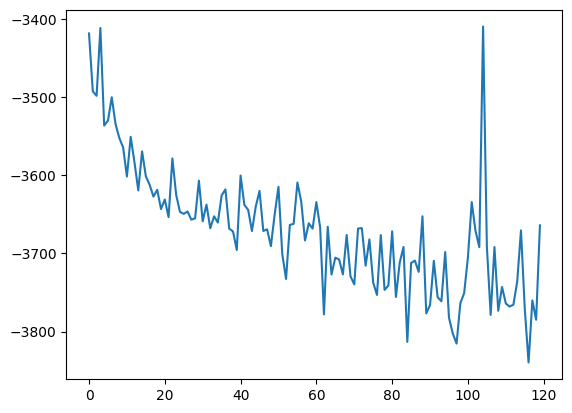

In [27]:
plt.plot([-3418.8599, -3492.8635, -3498.5342, -3411.8538, -3536.5781, -3530.2061, -3500.3779, -3534.7480, -3552.5205, -3564.5493, -3601.7537, -3551.0049, -3583.7090, -3619.4961, -3569.5752, -3601.4683, -3612.3320, -3627.4106, -3618.7007, -3643.3760, -3631.1201, -3653.6553, -3578.6118, -3625.1387, -3646.9365, -3649.4578, -3646.3921, -3656.9319, -3655.0942, -3607.0457, -3658.9541, -3637.6240, -3667.9048, -3652.5764, -3660.6016, -3625.9250, -3618.2256, -3668.4253, -3671.9258, -3695.6531, -3600.4783, -3637.9790, -3644.4539, -3671.4290, -3640.2124, -3620.1335, -3671.3674, -3669.1946, -3690.7566, -3649.9402, -3614.8271, -3700.6831, -3732.7200, -3663.6143, -3662.2312, -3609.4062, -3633.5303, -3683.4070, -3661.4604, -3668.3787, -3634.4138, -3666.9814, -3777.9834, -3665.9648, -3726.9534, -3705.4600, -3707.7568, -3726.8501, -3676.5083, -3729.2280, -3739.6284, -3668.2693, -3667.6855, -3715.7334, -3682.1011, -3737.4023, -3753.1501, -3676.6133, -3746.7251, -3741.1255, -3671.7583, -3755.6660, -3711.6636, -3691.8328, -3813.1809, -3712.2317, -3709.1780, -3723.6509, -3652.5591, -3776.7241, -3766.0601, -3709.5276, -3755.9863, -3761.2163, -3698.3188, -3782.3203, -3802.4380, -3815.2969, -3763.5752, -3750.8904, -3704.8337, -3634.4241, -3671.3423, -3692.0032, -3409.9250, -3691.5654, -3778.6646, -3691.9370, -3773.3499, -3742.9207, -3764.0356, -3767.9910, -3765.5415, -3736.0254, -3670.6245, -3770.8818, -3839.4521, -3760.1458, -3784.7710, -3664.2041])

In [17]:
metrics

{'log_weight': Array([[ 3166.1648,  4162.8535,  4444.6357,  3881.3381,  3460.7197,
          3581.114 ,  2545.3223,  2962.6821,  3083.7556,  4930.028 ,
          3666.415 ,  3760.9216,  3863.5405,  3826.331 ,  4083.6863,
          3815.6887,  3183.9888,  4176.1143,  3320.7097,  3423.9712,
          4445.329 ,  3330.9934,  3607.8523,  4208.811 ,  2593.615 ,
          4357.3647,  3226.669 ,  3064.533 ,  4221.7456,  3778.0686,
          4646.053 ,  1944.524 ,  2373.5166,  3537.8323,  3796.7375,
          4293.7007,  2532.4653,  3439.879 ,  3578.4565,  4069.829 ,
          4091.3152,  3859.321 ,  3600.4126,  4175.106 ,  4214.868 ,
          4034.1091,  3104.9753,  3757.3767,  2949.103 ,  4529.1616,
          6177.971 ,  2271.2822,  3550.8936,  2764.004 ,  3611.071 ,
          3746.2727,  6902.2246,  2691.51  ,  2752.451 ,  3189.0632,
          3543.8816,  3424.7925,  7343.257 ,  1777.0947,  4086.825 ,
          3839.379 ,  3977.338 ,  4362.2754,  3214.4348,  3217.546 ,
          5506.8784,

In [18]:
np.save("worm_sleep_phase_learned_params.npy", wormsim_params)

In [19]:
T = 10
D = 2
network = coix.util.BindModule(wormsim_net, wormsim_params)
make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-2)
make_batch_plate = lambda: numpyro.plate("batch", batch_size, dim=-1)
target = make_particle_plate()(make_batch_plate()(partial(wormsim_target, network, D=D, T=T)))
shuffle_rng, rng_key = random.split(jax.random.PRNGKey(0))
# sample from the target
out_model, tr_model, _ = coix.traced_evaluate(target, seed=jax.random.PRNGKey(rng_key[0]))(
    None, sleep_phase=False
)
model_sample = {k: v["value"] for k, v in tr_model.items()}
proposal_io = {**out_model[0], **model_sample}
q = make_proposal(network, make_particle_plate, T=T)
# out_q, tr_q, metrics = coix.traced_evaluate(q, seed=jax.random.PRNGKey(rng_key[1]))(proposal_io, sleep_phase=False)
out_q, tr_q, metrics = coix.traced_evaluate(propose(target, q), seed=jax.random.PRNGKey(rng_key[1]))(out_model[0]['frames_recon'], sleep_phase=False)


In [20]:
tr_q.keys()

dict_keys(['L', 'A', 'T', 'kw', 'ku', 'inc', 'dr', 'phase_1', 'phase_2', 'phase_3', 'alpha', 'z_where_0_0', 'z_where_0_1', 'z_where_0_2', 'z_where_0_3', 'z_where_0_4', 'z_where_0_5', 'z_where_0_6', 'z_where_0_7', 'z_where_0_8', 'z_where_0_9', 'z_where_1_0', 'z_where_1_1', 'z_where_1_2', 'z_where_1_3', 'z_where_1_4', 'z_where_1_5', 'z_where_1_6', 'z_where_1_7', 'z_where_1_8', 'z_where_1_9', 'z_what_0', 'z_what_1', 'z_what_2', 'z_what_3', 'z_what_4', 'z_what_5', 'z_what_6', 'z_what_7', 'z_what_8', 'z_what_9', 'frames'])

In [21]:
out_model[0]['frames_recon'].shape

(1, 512, 10, 64, 64)

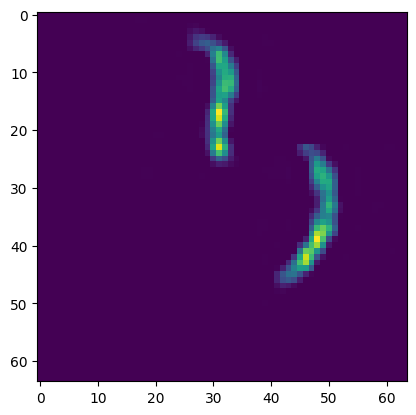

In [22]:
plt.imshow(out_model[0]['frames_recon'][0, 0, 0])

In [23]:
out_q[0].keys()

dict_keys(['frames', 'frames_recon', 'worms', 'z_what_0', 'z_what_1', 'z_what_2', 'z_what_3', 'z_what_4', 'z_what_5', 'z_what_6', 'z_what_7', 'z_what_8', 'z_what_9', 'worm_frames', 'params', 'z_where_0', 'z_where_1', 'z_where_2', 'z_where_3', 'z_where_4', 'z_where_5', 'z_where_6', 'z_where_7', 'z_where_8', 'z_where_9'])

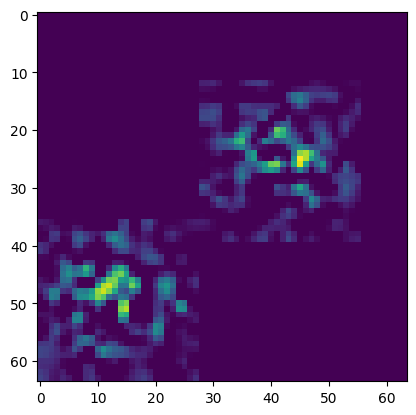

In [29]:
plt.imshow(out_q[0]['frames_recon'][0, 0, 0])

In [25]:
tr_q.keys()

dict_keys(['L', 'A', 'T', 'kw', 'ku', 'inc', 'dr', 'phase_1', 'phase_2', 'phase_3', 'alpha', 'z_where_0_0', 'z_where_0_1', 'z_where_0_2', 'z_where_0_3', 'z_where_0_4', 'z_where_0_5', 'z_where_0_6', 'z_where_0_7', 'z_where_0_8', 'z_where_0_9', 'z_where_1_0', 'z_where_1_1', 'z_where_1_2', 'z_where_1_3', 'z_where_1_4', 'z_where_1_5', 'z_where_1_6', 'z_where_1_7', 'z_where_1_8', 'z_where_1_9', 'z_what_0', 'z_what_1', 'z_what_2', 'z_what_3', 'z_what_4', 'z_what_5', 'z_what_6', 'z_what_7', 'z_what_8', 'z_what_9', 'frames'])